In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
#import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import preprocessing
import pathlib
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split,GridSearchCV
import pandas as pd
from collections import Counter,defaultdict
import seaborn as sns
import os
import time
import imagehash
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.patches as patches
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples,confusion_matrix,recall_score,precision_score
import matplotlib.cm as cm
from sklearn.model_selection import KFold

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#bee_df = tfds.as_dataframe(bee_ds,bee_info)
bee_df = pd.read_json("C:/Users/javip/god/bees.json")

In [4]:
bee_df.head()

,input,output/cooling_output,output/pollen_output,output/varroa_output,output/wasps_output
0,"[[[88, 85, 78], [97, 97, 87], [108, 111, 100],...",0,0,0,0
1,"[[[133, 224, 183], [134, 225, 184], [134, 226,...",0,1,0,0
2,"[[[91, 94, 85], [86, 89, 80], [79, 82, 75], [7...",0,1,0,0
3,"[[[151, 227, 181], [151, 227, 181], [154, 230,...",0,1,0,0
4,"[[[138, 223, 190], [136, 221, 188], [135, 222,...",0,0,0,0


In [5]:
bee_df.tail()

,input,output/cooling_output,output/pollen_output,output/varroa_output,output/wasps_output
7485,"[[[132, 223, 190], [131, 222, 189], [131, 222,...",1,0,0,0
7486,"[[[140, 222, 182], [139, 221, 181], [142, 224,...",0,1,0,0
7487,"[[[119, 103, 103], [121, 107, 106], [108, 94, ...",0,1,0,0
7488,"[[[125, 227, 190], [123, 225, 188], [123, 225,...",0,0,0,1
7489,"[[[132, 226, 189], [129, 223, 186], [127, 221,...",0,0,1,0


In [6]:
for i in range(len(bee_df["input"])):
    bee_df["input"].loc[i]=np.array(bee_df["input"][i])

In [7]:
print("Size of a image:",bee_df['input'][0].shape)

Size of a image: (150, 75, 3)


In [8]:
#Checking for Missing values
bee_df.isna().value_counts()

input  output/cooling_output  output/pollen_output  output/varroa_output  output/wasps_output
False  False                  False                 False                 False                  7490
dtype: int64

In [9]:
def convert_to_grayscale(img):
  #Convert to tensor
  tensor_img = tf.convert_to_tensor(img)
  #Convert from rgb to grayscale
  img_bw = tf.image.rgb_to_grayscale(tensor_img)

  return img_bw

def hash_image(img):
  img_bw = convert_to_grayscale(img)
  #Hash Image
  #hash_img = str(imagehash.phash(tf.keras.utils.array_to_img(img_bw.numpy())))
  hash_img = str(imagehash.phash(tf.keras.preprocessing.image.array_to_img(img_bw.numpy())))
  return hash_img

In [10]:
counts_imgs = dict()
arr_dups = list()
#Loop over images
for i, img in enumerate(bee_df['input'].values):
  #hash image
  hash_img = hash_image(img)
  #Add to dataframe
  bee_df.loc[i,'hash'] = hash_img

In [11]:
bee_df.loc[i,'hash']

'e53884cdda4e19dc'

In [12]:
bee_df.head(3)

,input,output/cooling_output,output/pollen_output,output/varroa_output,output/wasps_output,hash
0,"[[[88, 85, 78], [97, 97, 87], [108, 111, 100],...",0,0,0,0,a60d87169ea3d9d8
1,"[[[133, 224, 183], [134, 225, 184], [134, 226,...",0,1,0,0,e738920fda8789d8
2,"[[[91, 94, 85], [86, 89, 80], [79, 82, 75], [7...",0,1,0,0,a70fc8c307c9d333


In [13]:
#Loop over array of indexes of duplicated images
dups = bee_df.index[bee_df.duplicated(subset=['hash'],keep=False)]
dups

Int64Index([4298, 5922, 6012, 7294], dtype='int64')

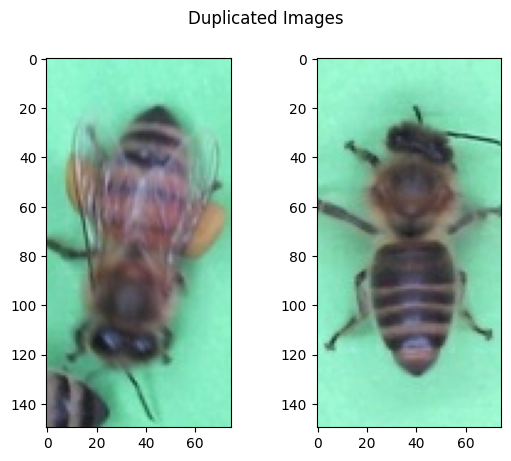

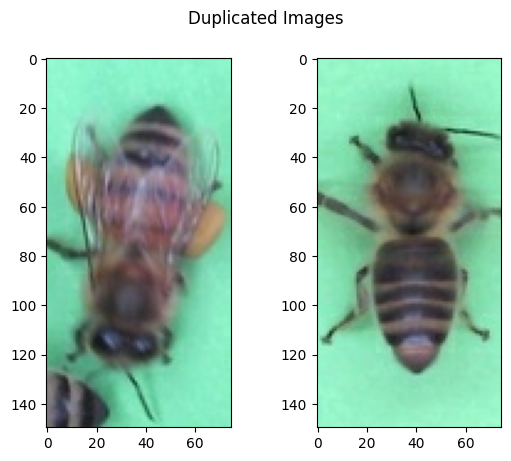

In [14]:
def plot_image(df,img_index,axe=None):
  """
get_image: Plots image
Arguments:
  df = DataFrame where images are stored
  img_index = position of image
  axe = pass axe to plot if subplots are needed
"""
  if axe is not None:
    #axe.imshow(tf.keras.utils.array_to_img(df.loc[img_index,'input']))
    axe.imshow(tf.keras.preprocessing.image.array_to_img(df.loc[img_index,'input']))
  else:
    #plt.imshow(tf.keras.utils.array_to_img(df.loc[img_index,'input']))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(df.loc[img_index,'input']))
    plt.show()

for i in range(0,len(dups)-1,2):
  #Set axis to plot images
  fig, (ax1, ax2) = plt.subplots(1,2)
  #Set title
  fig.suptitle("Duplicated Images")
  #Plot images
  plot_image(bee_df,dups[i],ax1)
  plot_image(bee_df,dups[i+1],ax2)

In [15]:
bee_df = bee_df.drop(dups)

In [16]:
"""
plot_class_counts: Plots a barplot with the respective number of instances existed on the dataset for a given target variable
Arguments:
  df = DataFrame to perform the counting (pd.DataFrame)
  target = target variable/class to count the number of examples (string)
  title = title of the plot (string)
  labels = labels to be plotted on the x axis (list of strings)
"""
def plot_class_counts(df,target,title,labels):
    fig,ax = plt.subplots(figsize=(6,6))
    #vals = df.value_counts(subset=[target])
    blist = plt.bar(labels,df.value_counts(subset=[target]),color=['#30A5BF','#F2BE22'])
    #blist[1].set_color('y')
    plt.title(title)
    total = len(df.values)
    for p in ax.patches:
      #Get percentages for classes
          percentage = '{:.1f}%'.format(100 * (p.get_height()/total))
          x = p.get_x() + p.get_width()/2 - 0.05
          y = p.get_y() + p.get_height() + 50
          ax.annotate(percentage, (x, y))
      #Get absolute values for classes
          x = p.get_x() + p.get_width()/2 - 0.05
          y = p.get_y() + p.get_height()/2
          ax.annotate(p.get_height(),(x,y))

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [18]:
#Parte 3, reconocimiento de labor en la colmena, modelo multiclase

In [19]:
bee_df_copy3=bee_df

Normalizacion de las imagenes

In [20]:
bee_df_copy3["input"]=bee_df_copy3["input"]/255.0

Me quedo unicamente con las abejas, las avispas no me interesan

In [21]:
# Selecciona un label específico para delimitar el dataset a unicamente las abejas
target_label = 0.0

# Filtra el DataFrame para obtener solo las muestras con el label objetivo
df_target3 = bee_df[bee_df_copy3["output/wasps_output"] == target_label]
df_target3=df_target3.reset_index(drop=True)

Creo una nueva columna en el dataset (objetivo) para llenarla con arrays de 3 elementos indicando la labor en la colmena de la abeja dependiendo de la posicion del 1, [1,0,0] - Cooling, [0,1,0] - Polen, [0,0,1] - Sin tarea 

In [22]:
df_target3['target'] = None

In [23]:
for i  in range (len(df_target3)):
  if df_target3['output/cooling_output'][i] == 1.0:
    df_target3['target'][i]=[1,0,0] #Cooling
  elif df_target3['output/pollen_output'][i] == 1.0:
    df_target3['target'][i]=[0,1,0] #Polen
  else:
    df_target3['target'][i]=[0,0,1] #Sin tarea

In [24]:
#Checking for Missing values
df_target3.isna().value_counts()

input  output/cooling_output  output/pollen_output  output/varroa_output  output/wasps_output  hash   target
False  False                  False                 False                 False                False  False     6536
dtype: int64

Separo datos y labels, y en train y test

In [25]:
X3=[]
Y3=[]

for i in range (len(df_target3)):
  image=df_target3["input"].loc[i]
  X3.append(image)
  Y3.append(df_target3["target"].loc[i])

In [26]:
X3=np.array(X3)
Y3=np.array(Y3)

In [27]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, Y3, test_size=0.2, random_state=42)

In [28]:
model3 = Sequential()

# Agregar capas convolucionales y de pooling
model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 75, 3)))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))

# Aplanar y agregar capas densas (fully connected)
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(3, activation='sigmoid'))

# Compilar el modelo
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 73, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 36, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 17, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 15, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 7, 128)        0         
_________________________________________________________________
flatten (Flatten)            (None, 15232)             0

In [29]:
history = model3.fit(X3_train, y3_train, epochs=20, batch_size = 80,
                    validation_data=(X3_test, y3_test))

Epoch 1/20
66/66 [==============================] - 13s 93ms/step - loss: 0.7933 - accuracy: 0.6901 - val_loss: 0.4415 - val_accuracy: 0.8280
Epoch 2/20
66/66 [==============================] - 5s 83ms/step - loss: 0.3316 - accuracy: 0.8575 - val_loss: 0.2692 - val_accuracy: 0.8991
Epoch 3/20
66/66 [==============================] - 5s 74ms/step - loss: 0.2134 - accuracy: 0.9220 - val_loss: 0.1972 - val_accuracy: 0.9304
Epoch 4/20
66/66 [==============================] - 5s 71ms/step - loss: 0.1850 - accuracy: 0.9260 - val_loss: 0.1604 - val_accuracy: 0.9472
Epoch 5/20
66/66 [==============================] - 5s 72ms/step - loss: 0.1509 - accuracy: 0.9409 - val_loss: 0.1554 - val_accuracy: 0.9511
Epoch 6/20
66/66 [==============================] - 5s 72ms/step - loss: 0.1328 - accuracy: 0.9485 - val_loss: 0.1354 - val_accuracy: 0.9549
Epoch 7/20
66/66 [==============================] - 5s 72ms/step - loss: 0.1044 - accuracy: 0.9617 - val_loss: 0.1485 - val_accuracy: 0.9488
Epoch 8/20
6

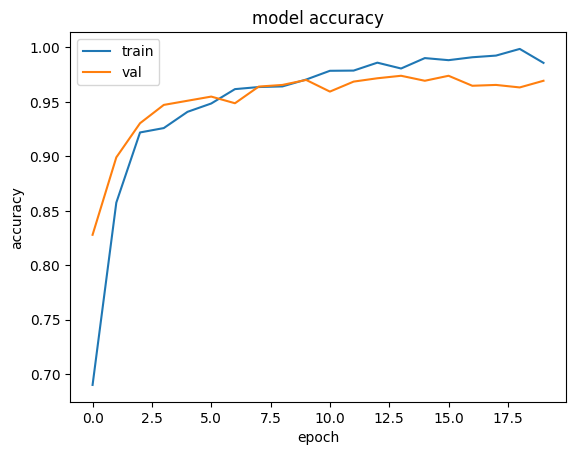

In [30]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

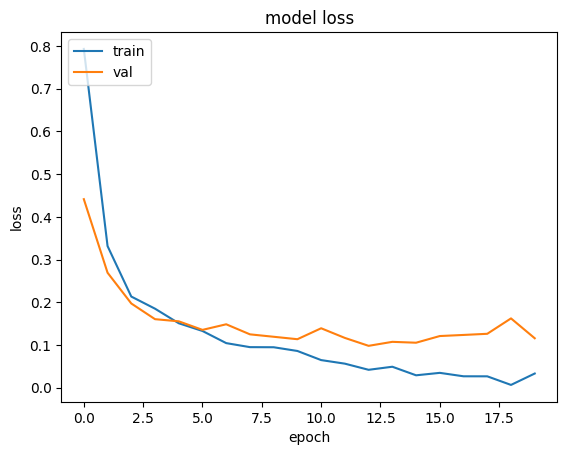

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
model3.evaluate(X3_test, y3_test)

41/41 [==============================] - 1s 10ms/step - loss: 0.1158 - accuracy: 0.9694


[0.11575949937105179, 0.9694189429283142]

Volvemos a ver resultados muy buenos sin overfit